bool_masked_pos shape: torch.Size([1, 2304])
Number of masked patches: 169
This is bool_masked_pos: tensor([[False, False, False,  ..., False, False, False]])
Reconstructed pixel values shape: torch.Size([1, 3, 192, 192])
Loss: 0.1850758045911789
Original image shape: (192, 192, 3)
Reconstructed image shape: (192, 192, 3)
Mean Squared Error (MSE) between original and masked image: 0.0015622549
Mean Squared Error (MSE) between original and reconstructed image: 0.12919945


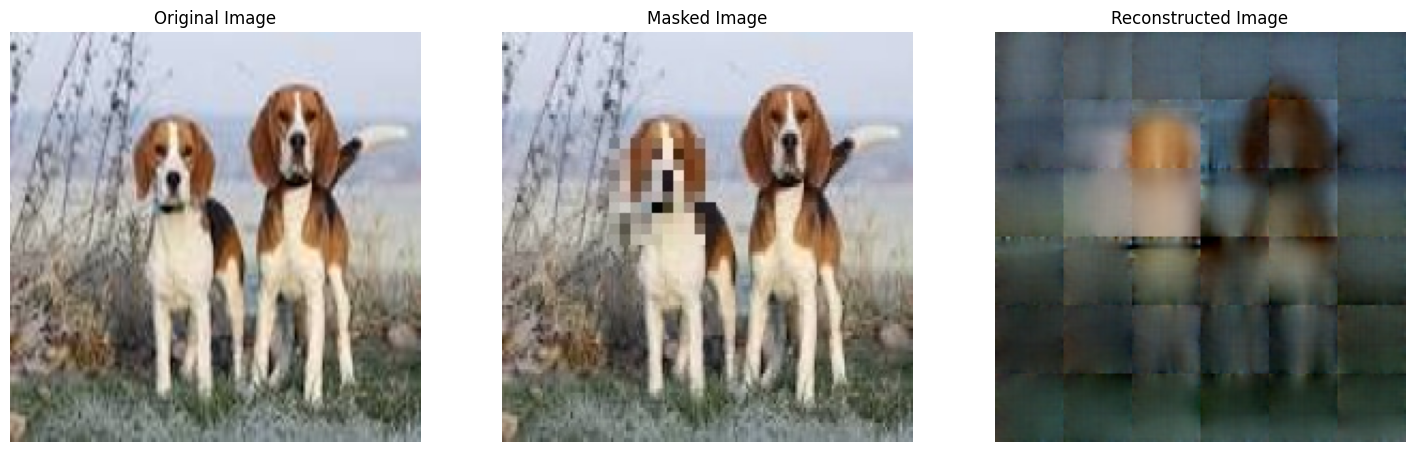

In [2]:
from transformers import AutoImageProcessor, SwinForMaskedImageModeling
from PIL import Image
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from torchvision import transforms

# Load and convert original and masked images to RGB
original_image_path = "tryorigin.png"
masked_image_path = "trymask.png"  # Path to the masked image

original_image = Image.open(original_image_path).convert("RGB")
masked_image = Image.open(masked_image_path).convert("RGB")

# Step 1: Resize the image
model_image_size = 192
original_image = original_image.resize((model_image_size, model_image_size))
masked_image = masked_image.resize((model_image_size, model_image_size))

# Step 2: Convert the resized image to a NumPy array
masked_image_np = np.array(masked_image).astype(np.float32) / 255.0  # Normalized to [0, 1]

# Step 3: Rearrange the axes to match the format (C, H, W)
masked_image_np = np.transpose(masked_image_np, (2, 0, 1))  # Convert from (H, W, C) to (C, H, W)

# Step 4: Convert to a PyTorch tensor and add a batch dimension
pixel_values_masked = torch.tensor(masked_image_np).unsqueeze(0)  # Shape: (1, 3, 192, 192)

# Initialize processor and model
processor_path = "processor"
model_path = "model"

image_processor = AutoImageProcessor.from_pretrained(processor_path)
model = SwinForMaskedImageModeling.from_pretrained(model_path, ignore_mismatched_sizes=True)

# Process original image (using processor for comparison)
# pixel_values_original = image_processor(images=original_image, return_tensors="pt").pixel_values

# Calculate the number of patches per row and total patches
patch_size = model.config.patch_size  # Should be 4
num_patches_per_row = model_image_size // patch_size  # 192 // 4 = 48
num_patches = num_patches_per_row ** 2  # 48 * 48 = 2304

# Initialize bool_masked_pos
bool_masked_pos = torch.zeros((1, num_patches), dtype=torch.bool)

# Mosaic parameters (consistent with image masking)
mosaic_start_x = 50
mosaic_start_y = 50
mosaic_width = 50
mosaic_height = 50

# Convert pixel coordinates to patch indices
start_patch_x = mosaic_start_x // patch_size
start_patch_y = mosaic_start_y // patch_size
end_patch_x = (mosaic_start_x + mosaic_width) // patch_size
end_patch_y = (mosaic_start_y + mosaic_height) // patch_size

# Apply mask to the corresponding patches
for i in range(start_patch_y, end_patch_y):
    for j in range(start_patch_x, end_patch_x):
        patch_index = i * num_patches_per_row + j
        bool_masked_pos[0, patch_index] = True

# # Add some additional random patches for masking
# num_additional_masks = 30  # for example, mask 30 more random patches
# additional_masks = torch.randint(0, num_patches, (num_additional_masks,))
# bool_masked_pos[0, additional_masks] = True

print("bool_masked_pos shape:", bool_masked_pos.shape)
print("Number of masked patches:", bool_masked_pos.sum().item())

# Run the model with the masked image
outputs = model(
    pixel_values_masked,
    bool_masked_pos=bool_masked_pos
)
print("This is bool_masked_pos:", bool_masked_pos)

loss, reconstructed_pixel_values = outputs.loss, outputs.reconstruction

# Print results
print("Reconstructed pixel values shape:", reconstructed_pixel_values.shape)
print("Loss:", loss.item())

# Convert reconstructed pixel values to image
reconstructed_image_np = reconstructed_pixel_values.squeeze().permute(1, 2, 0).detach().cpu().numpy()

# Clip and normalize
reconstructed_image_np = np.clip(reconstructed_image_np, 0, 1)  # Ensure values are in [0, 1]

# Ensure consistent shape with original image
reconstructed_image_np = np.array(reconstructed_image_np).astype(np.float32)

# Convert original image to numpy array for comparison
original_image_np = np.array(original_image).astype(np.float32) / 255.0  # Normalize to [0, 1]
masked_image_np = np.array(masked_image).astype(np.float32) / 255.0

# Check the shapes before calculating MSE
print("Original image shape:", original_image_np.shape)          # Should be (192, 192, 3)
print("Reconstructed image shape:", reconstructed_image_np.shape)  # Should be (192, 192, 3)

# If needed, resize the reconstructed image to match the original
if reconstructed_image_np.shape != original_image_np.shape:
    reconstructed_image_np = np.array(
        Image.fromarray((reconstructed_image_np * 255).astype(np.uint8)).resize((192, 192))
    ).astype(np.float32) / 255.0

# Calculate MSE
mse = mean_squared_error(original_image_np.flatten(), reconstructed_image_np.flatten())
mse_masked = mean_squared_error(original_image_np.flatten(), masked_image_np.flatten())

print("Mean Squared Error (MSE) between original and masked image:", mse_masked)
print("Mean Squared Error (MSE) between original and reconstructed image:", mse)

# Display images
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(original_image_np)
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(masked_image_np)
axes[1].set_title("Masked Image")
axes[1].axis("off")

axes[2].imshow(reconstructed_image_np)
axes[2].set_title("Reconstructed Image")
axes[2].axis("off")

plt.show()


In [25]:
image_processor = AutoImageProcessor.from_pretrained("microsoft/swin-base-simmim-window6-192")
model = SwinForMaskedImageModeling.from_pretrained("microsoft/swin-base-simmim-window6-192")
model.save_pretrained(model_path)
image_processor.save_pretrained(processor_path)

['processor/preprocessor_config.json']

In [27]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
from transformers import AutoImageProcessor, SwinForMaskedImageModeling
from PIL import Image
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from torchvision import transforms


class MaskedImageDataset(Dataset):
    def __init__(self, original_dir, masked_dir, image_size):
        self.original_dir = original_dir
        self.masked_dir = masked_dir
        self.image_size = image_size
        self.original_images = sorted(os.listdir(original_dir))
        self.masked_images = sorted(os.listdir(masked_dir))

        # Filter out invalid images
        self.original_images = [img for img in self.original_images if self.is_valid_image(os.path.join(original_dir, img))]
        self.masked_images = [img for img in self.masked_images if self.is_valid_image(os.path.join(masked_dir, img))]

    def __len__(self):
        return len(self.original_images)

    def __getitem__(self, idx):
        original_image = Image.open(os.path.join(self.original_dir, self.original_images[idx])).convert("RGB")
        masked_image = Image.open(os.path.join(self.masked_dir, self.masked_images[idx])).convert("RGB")
        original_image = original_image.resize((self.image_size, self.image_size))
        masked_image = masked_image.resize((self.image_size, self.image_size))
        original_image_tensor = torch.tensor(np.array(original_image).astype(np.float32) / 255.0).permute(2, 0, 1)
        masked_image_tensor = torch.tensor(np.array(masked_image).astype(np.float32) / 255.0).permute(2, 0, 1)
        return masked_image_tensor, original_image_tensor

    @staticmethod
    def is_valid_image(filepath):
        try:
            with Image.open(filepath) as img:
                img.verify()  # Check if it is a valid image
            return True
        except (IOError, SyntaxError):
            return False


# Directories containing images
original_dir = "data/dataset/Beagle"
masked_dir = "new_dataset/Beagle_black"
image_size = 192

# Initialize dataset and dataloader
dataset = MaskedImageDataset(original_dir, masked_dir, image_size)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)


In [28]:
from torch.utils.data import random_split
# Calculate sizes for training and testing
total_size = len(dataset)
train_size = int(0.8 * total_size)
test_size = total_size - train_size

# Split the dataset
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Initialize DataLoaders for training and testing
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [35]:
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from PIL import Image
import os
import numpy as np
from sklearn.model_selection import train_test_split


class MaskedImageDataset(Dataset):
    def __init__(self, original_dir, masked_dirs, image_size):
        self.original_dir = original_dir
        self.masked_dirs = masked_dirs
        self.image_size = image_size

        self.original_images = sorted(os.listdir(original_dir))
        self.masked_images = []

        # Collect images from all masked directories
        for masked_dir in masked_dirs:
            masked_images = sorted(os.listdir(masked_dir))
            self.masked_images.extend([(masked_dir, img) for img in masked_images])

        # Filter out invalid images
        self.original_images = [img for img in self.original_images if self.is_valid_image(os.path.join(original_dir, img))]
        self.masked_images = [entry for entry in self.masked_images if self.is_valid_image(os.path.join(entry[0], entry[1]))]

    def __len__(self):
        return len(self.original_images)

    def __getitem__(self, idx):
        original_image_name = self.original_images[idx]
        masked_dir, masked_image_name = self.masked_images[idx]

        original_image = Image.open(os.path.join(self.original_dir, original_image_name)).convert("RGB")
        masked_image = Image.open(os.path.join(masked_dir, masked_image_name)).convert("RGB")

        original_image = original_image.resize((self.image_size, self.image_size))
        masked_image = masked_image.resize((self.image_size, self.image_size))

        original_image_tensor = torch.tensor(np.array(original_image).astype(np.float32) / 255.0).permute(2, 0, 1)
        masked_image_tensor = torch.tensor(np.array(masked_image).astype(np.float32) / 255.0).permute(2, 0, 1)

        return masked_image_tensor, original_image_tensor

    @staticmethod
    def is_valid_image(filepath):
        try:
            with Image.open(filepath) as img:
                img.verify()  # Check if it is a valid image
            return True
        except (IOError, SyntaxError):
            return False


def split_dataset_per_breed(original_dir, masked_root_dir, image_size, train_ratio=0.8):
    breed_name = os.path.basename(original_dir)
    masked_dirs = [os.path.join(masked_root_dir, f"{breed_name}_{color}") for color in ["black", "blue", "red", "white", "yellow"]]
    
    dataset = MaskedImageDataset(original_dir, masked_dirs, image_size)
    
    # Calculate sizes for splits
    total_size = len(dataset)
    train_size = int(train_ratio * total_size)
    test_size = total_size - train_size

    indices = list(range(total_size))
    train_indices, test_indices = train_test_split(indices, train_size=train_size, random_state=42)
    
    train_subset = Subset(dataset, train_indices)
    test_subset = Subset(dataset, test_indices)
    
    return train_subset, test_subset


# Directories containing images
original_dirs = [
    "data/dataset/Beagle",
    "data/dataset/Boxer",
    "data/dataset/Bulldog",
    "data/dataset/Dachshund",
    "data/dataset/German_Shepherd"
]
masked_root_dir = "new_dataset_8080"
image_size = 192

# Splitting datasets for each breed
train_datasets = []
test_datasets = []

for original_dir in original_dirs:
    train_subset, test_subset = split_dataset_per_breed(original_dir, masked_root_dir, image_size)
    train_datasets.append(train_subset)
    test_datasets.append(test_subset)

# Combine datasets from all breeds
train_dataset = torch.utils.data.ConcatDataset(train_datasets)
test_dataset = torch.utils.data.ConcatDataset(test_datasets)

# Initialize DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False)

In [36]:
len(test_datasets)

5

In [37]:
from transformers import AutoImageProcessor, SwinForMaskedImageModeling

# Load model and processor
processor_path = "processor"  # Replace with actual path
model_path = "model"          # Replace with actual path

image_processor = AutoImageProcessor.from_pretrained(processor_path)
model = SwinForMaskedImageModeling.from_pretrained(model_path, ignore_mismatched_sizes=True)


In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR

# Initialize loss function
criterion = nn.MSELoss()

# Initialize optimizer with weight decay
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)

# Cosine learning rate scheduler
scheduler = CosineAnnealingLR(optimizer, T_max=10)  # 10 epochs

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Number of epochs
num_epochs = 10

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for masked_images, original_images in train_dataloader:
        masked_images = masked_images.to(device)
        original_images = original_images.to(device)

        # Generate mask positions
        batch_size, _, height, width = masked_images.shape
        patch_size = model.config.patch_size
        num_patches_per_row = height // patch_size
        num_patches = num_patches_per_row ** 2
        bool_masked_pos = torch.zeros((batch_size, num_patches), dtype=torch.bool).to(device)

        # Example: Random masking
        for i in range(batch_size):
            mask_indices = torch.randint(0, num_patches, (num_patches // 10,))  # Mask 10% patches
            bool_masked_pos[i, mask_indices] = True

        # Forward pass
        outputs = model(pixel_values=masked_images, bool_masked_pos=bool_masked_pos)
        loss = criterion(outputs.reconstruction, original_images)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Step the scheduler
    scheduler.step()

    avg_loss = total_loss / len(train_dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}")

    # Save model after each epoch
    model.save_pretrained(f"fine_tuned_model_epoch_{epoch+1}")


KeyboardInterrupt: 

In [23]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

def evaluate_and_reconstruct(model, dataloader, save_reconstructions=False, output_dir="reconstructed_images"):
    model.eval()
    mse = 0.0
    total_samples = 0
    reconstructed_images_list = []

    with torch.no_grad():
        for batch_idx, (masked_images, original_images) in enumerate(dataloader):
            masked_images = masked_images.to(device)
            original_images = original_images.to(device)

            # Generate mask positions (same as training)
            batch_size, _, height, width = masked_images.shape
            patch_size = model.config.patch_size
            num_patches_per_row = height // patch_size
            num_patches = num_patches_per_row ** 2
            bool_masked_pos = torch.zeros((batch_size, num_patches), dtype=torch.bool).to(device)

            outputs = model(pixel_values=masked_images, bool_masked_pos=bool_masked_pos)
            reconstructed_images = outputs.reconstruction

            # Calculate MSE
            mse += nn.functional.mse_loss(reconstructed_images, original_images, reduction="sum").item()
            total_samples += batch_size

            # Convert reconstructed images to numpy for saving/visualization
            reconstructed_images_np = (
                reconstructed_images.cpu().permute(0, 2, 3, 1).numpy()
            )  # Shape: (batch_size, height, width, channels)
            reconstructed_images_np = np.clip(reconstructed_images_np, 0, 1)  # Ensure values are in [0, 1]

            # Save or visualize
            if save_reconstructions:
                for i in range(batch_size):
                    img = (reconstructed_images_np[i] * 255).astype(np.uint8)  # Convert to [0, 255]
                    Image.fromarray(img).save(f"{output_dir}/reconstructed_{batch_idx * batch_size + i}.png")
                   


            reconstructed_images_list.append(reconstructed_images_np)

    mse = mse / total_samples  # Average MSE
    return mse, np.concatenate(reconstructed_images_list, axis=0)


In [24]:
# ["black", "blue", "red", "white", "yellow"]
for i in range(len(test_datasets)):
    test_dataloader = DataLoader(test_datasets[i], batch_size=8, shuffle=False)
    val_loss, reconstructed_images = evaluate_and_reconstruct(
        model,
        test_dataloader,
        save_reconstructions=True,
        output_dir="./reconstructed_images_1"
    )
    print(f"Validation MSE: {val_loss:.4f}")


Validation MSE: 264.0819
Validation MSE: 262.3503
Validation MSE: 271.5393
Validation MSE: 312.3036
Validation MSE: 280.4875
